In [23]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns

The dataset consists of daily forest fire records from a protected area in Portugal. Each instance describes where and when a fire occurred (grid coordinates X, Y, month, day), the corresponding fire weather indices (FFMC, DMC, DC, ISI), and basic meteorological conditions (temperature, relative humidity, wind speed, and rainfall). Our prediction target is the burned area of each fire event, modeled in log-transformed form area_log = ln(area + 1) to handle the heavy skew of the original area distribution.

In [24]:
df = pd.read_csv("forestfires_cleaned.csv")
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,month_idx,day_idx,area_log
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,3,5,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,10,2,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,10,6,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,3,5,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,3,7,0.0


In [25]:
df_clean = df.drop(columns=["month", "day"])

y = df_clean["area_log"]
X = df_clean.drop(columns=["area", "area_log"])

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

X_train.shape, X_test.shape

((410, 12), (103, 12))

In [27]:
def evaluate(true, pred):
    return {
        "RMSE_log": np.sqrt(mean_squared_error(true, pred)),
        "MAE_log": mean_absolute_error(true, pred),
        "R2_log": r2_score(true, pred)
    }

We use RMSE, MAE, and R² together because each captures a different and essential aspect of wildfire burn area prediction. 


RMSE emphasizes large errors and therefore reflects the operational risk of severely underestimating major fires.
 

MAE provides a stable measure of average daily prediction accuracy, which is important given that most recorded fires are very small. 

R² indicates how much variance in burned area can be explained by meteorological conditions, acknowledging that fire behavior is highly stochastic and influenced by factors outside the dataset. 

Together, these three metrics provide a balanced and comprehensive evaluation of model performance.


## Random Forest

In [36]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

evaluate(y_test, y_pred_rf)

{'RMSE_log': np.float64(1.3509685473891058),
 'MAE_log': 1.157382781231548,
 'R2_log': -0.0925212174011607}

In [37]:
rf_params = {
    "n_estimators": [200, 500, 800],
    "max_depth": [None, 10, 20, 30],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None]  
}

rf_grid = GridSearchCV(
    rf,
    param_grid=rf_params,
    cv=5,
    n_jobs=-1,
    scoring="neg_root_mean_squared_error",
)

rf_grid.fit(X_train, y_train)
rf_grid.best_params_

{'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'n_estimators': 800}

In [38]:
best_rf = rf_grid.best_estimator_
y_pred_rf_tuned = best_rf.predict(X_test)

evaluate(y_test, y_pred_rf_tuned)

{'RMSE_log': np.float64(1.2880049456437184),
 'MAE_log': 1.113494035669257,
 'R2_log': 0.00694234159347995}

## XGBOOST

In [39]:
xgb = XGBRegressor(
    objective="reg:squarederror",
    eval_metric="rmse",
    random_state=42
)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

evaluate(y_test, y_pred_xgb)

{'RMSE_log': np.float64(1.5020870604688357),
 'MAE_log': 1.2299768941491414,
 'R2_log': -0.35060892012124323}

In [40]:
xgb_params = {
    "n_estimators": [300, 600, 900],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7, 9],
    "subsample": [0.7, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

xgb_grid = GridSearchCV(
    xgb,
    param_grid=xgb_params,
    cv=5,
    n_jobs=-1,
    scoring="neg_root_mean_squared_error",
)

xgb_grid.fit(X_train, y_train)
xgb_grid.best_params_

{'colsample_bytree': 0.6,
 'learning_rate': 0.01,
 'max_depth': 3,
 'n_estimators': 300,
 'subsample': 1.0}

In [41]:
best_xgb = xgb_grid.best_estimator_
y_pred_xgb_tuned = best_xgb.predict(X_test)

evaluate(y_test, y_pred_xgb_tuned)

{'RMSE_log': np.float64(1.288239335361846),
 'MAE_log': 1.1058194013040803,
 'R2_log': 0.006580877634265292}

## MODEL COMPARISON (Need to be improved)

In [42]:
results = pd.DataFrame({
    "Model": ["RF_Baseline", "RF_Tuned", "XGB_Baseline", "XGB_Tuned"],
    "RMSE_log": [
        evaluate(y_test, y_pred_rf)["RMSE_log"],
        evaluate(y_test, y_pred_rf_tuned)["RMSE_log"],
        evaluate(y_test, y_pred_xgb)["RMSE_log"],
        evaluate(y_test, y_pred_xgb_tuned)["RMSE_log"]
    ],
    "MAE_log": [
        evaluate(y_test, y_pred_rf)["MAE_log"],
        evaluate(y_test, y_pred_rf_tuned)["MAE_log"],
        evaluate(y_test, y_pred_xgb)["MAE_log"],
        evaluate(y_test, y_pred_xgb_tuned)["MAE_log"]
    ]
})

results

,Model,RMSE_log,MAE_log
0,RF_Baseline,1.350969,1.157383
1,RF_Tuned,1.288005,1.113494
2,XGB_Baseline,1.502087,1.229977
3,XGB_Tuned,1.288239,1.105819


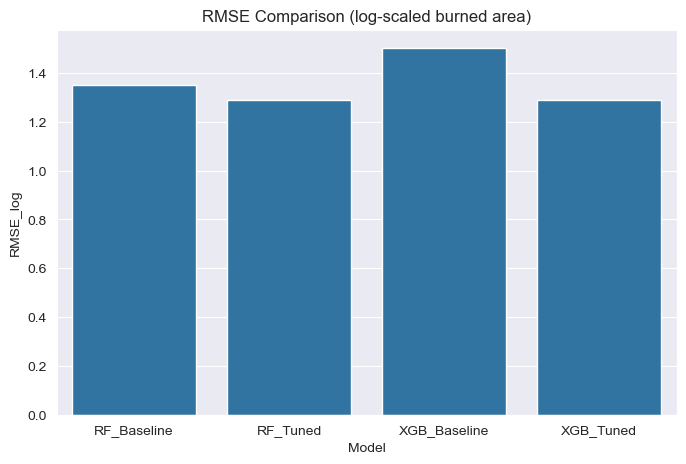

In [43]:
plt.figure(figsize=(8,5))
sns.barplot(data=results, x="Model", y="RMSE_log")
plt.title("RMSE Comparison (log-scaled burned area)")
plt.show()